# Imported Libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, LSTM, Input, Reshape 
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os

# Image Dataset Import

In [2]:
labels = ['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
img_size = 224
def get_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                crop_image= img_arr[0:1728,430:2190]
                resized_arr = cv2.resize(crop_image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#function call to get_data function that takes file path of the dataset.
data= get_data('dataset/all_equal_300_images/')

<ipython-input-2-b08f5e223f84>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
data.shape

(1200, 2)

In [5]:
type(data)

numpy.ndarray

# Dividing Data Ndarray into Normal, Cataract, Glaucoma and Retina diseases. 

In [6]:
normal= data[0:300]
normal.shape

(300, 2)

In [7]:
cataract=data[300:600]
cataract.shape

(300, 2)

In [8]:
glaucoma= data[600:900]
glaucoma.shape

(300, 2)

In [9]:
retina_disease= data[900:1200]
retina_disease.shape

(300, 2)

In [10]:
random.seed(20)
np.random.shuffle(normal)
np.random.shuffle(cataract)   
np.random.shuffle(glaucoma)
np.random.shuffle(retina_disease)

# Performing Normalization and Resize operation 

In [11]:
def normalize(x_train,x_val,x_test): 
    
    x_train = np.array(x_train) / 255
    x_train.reshape(-1, img_size, img_size, 1)
    
    x_test= np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1)    
    
    x_val= np.array(x_val) / 255
    x_val.reshape(-1, img_size, img_size, 1)    
        
    return (x_train,x_val,x_test) 

# Separating the Images and Labels into Respective Variables

In [12]:
def image_label_split(train,validation,test):
    
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
      x_train.append(feature)
      y_train.append(label)

    for feature, label in validation:
      x_val.append(feature)
      y_val.append(label)

    for feature, label in test:
      x_test.append(feature)
      y_test.append(label)
        
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test= np.array(y_test)
    
    return (x_train,y_train,x_val,y_val,x_test,y_test)


# InceptionResNetV2-LSTM MODEL

In [13]:
def model_build_compile(k):     
    baseModel = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
            layer.trainable = False

    x = baseModel.output

        # LSTM layer
    x = Reshape((25, 1536))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
    #     

        # FC layer
    x = Flatten(name="flatten")(x)

        # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
    #    

        # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
    #     

        # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(learning_rate=0.01, clipvalue=100)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    k=k+1
    print("model building and compiling for fold",k)
    return model

# Model prediction for Test Images and Computation of Sensitivity and Specificity

In [14]:
def test_pred(x_val,y_val,k):
    predictions = model.predict(x_val)
    predictions = np.argmax(predictions, axis = -1)
    
    print('----------------Test accuracy for',k+1,'fold----------------')
    #Confusion matrix, Accuracy, sensitivity and specificity
    cm1 = confusion_matrix(y_val,predictions)
    print('Confusion Matrix : \n', cm1)

    #####from confusion matrix calculate accuracy
    
    sensitivity_1_normal = (cm1[0,0])/(cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (cm1[1,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (cm1[2,2])/(cm1[2,0]+cm1[2,1]+cm1[2,2]+cm1[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (cm1[3,3])/(cm1[3,0]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])/(cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])/(cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])/(cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])/(cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(cm1))
    test_accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)
    print('-----------------------------End of',k+1,'Fold--------------------------')
    return test_accuracy,Specificity,Sensitivity,cm1


In [15]:
CM= []
test_accuracy=[]
test_sensitivity=[]
test_specificity=[]
train_acc = []
val_acc = []
train_loss = []
val_loss = []

# InceptionResNetV2-LSTM 5 Fold Cross Validation

In [16]:
for k in range (5): # for loop to run 5 folds 
    n=30  #specifying the number of images for each class in test phase,calulated as per 10% of total images in each class images 300.
    
    
    # Adding the images in normal validation set by using k*n to (k+1)*n as index values for normal dataset divided in cell 6.
    test_normal= normal[k*n:(k+1)*n]
    print('------------------------Start of',k+1,'Fold------------------------')
    print('test images for normal class from',k*n,(k+1)*n)
    
    # Adding the images in cataract validation set by using k*n to (k+1)*nas index values for cataract dataset divided in cell 7.
    test_cataract= cataract[k*n:(k+1)*n]
    print('test images for cataract class from',k*n,(k+1)*n)
    
    # Adding the images in gluacoma validation set by using k*nto (k+1)*n as index values for gluacoma dataset divided in cell 8.
    test_glaucoma= glaucoma[k*n:(k+1)*n]
    print('test images for glaucoma class from',k*n,(k+1)*n)
    
    # Adding the images in retina disease validation set by using k*n to (k+1)*n as index values for retina disease dataset divided in cell 9.
    test_retina= retina_disease[k*n:(k+1)*n]
    print('test images for retina disease class from',k*n,(k+1)*n)
    
    # Now for train and validation set of Normal images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 
    
    train_validation_normal= normal[:k*n] 
    train_validation_normal= np.append(train_validation_normal,normal[(k+1)*n:],axis=0)
    print('train_validation images for normal class from 0 to',k*n,'and',(k+1)*n,'to 300')
    
    # Now for train and validation set of cataract images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 
    
    train_validation_cataract= cataract[:k*n] 
    train_validation_cataract= np.append(train_validation_cataract,cataract[(k+1)*n:],axis=0)
    print('train_validation images for cataract class from 0 to',k*n,'and',(k+1)*n,'to 300')

    # Now for train and validation set of glaucoma images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 

    train_validation_glaucoma= glaucoma[:k*n] 
    train_validation_glaucoma= np.append(train_validation_glaucoma,glaucoma[(k+1)*n:],axis=0)
    print('train_validation  images for glaucoma class from 0',k*n,'and',(k+1)*n,'to 300')
    
    # Now for train and validation set of retina disease images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 

    train_validation_retina= retina_disease[:k*n] 
    train_validation_retina= np.append(train_validation_retina,retina_disease[(k+1)*n:],axis=0)
    print('train_validation images for retina disease class from 0 to',k*n,'and',(k+1)*n,'to 300')
        
    
    # Splitting the train validation datasets in 80:20 ratio which would eventually give us 70% images in train and 20% images in validation and 10% in test.

    normal_train, normal_validation                 = train_test_split(train_validation_normal, test_size=0.20, random_state=14,shuffle=True)
    cataract_train, cataract_validation             = train_test_split(train_validation_cataract, test_size=0.20, random_state=14,shuffle=True)
    glaucoma_train, glaucoma_validation             = train_test_split(train_validation_glaucoma, test_size=0.20, random_state=14,shuffle=True)
    retina_disease_train, retina_disease_validation = train_test_split(train_validation_retina, test_size=0.20, random_state=14,shuffle=True)

    # Appending all train set images for all classes
    train= np.append(normal_train,cataract_train,axis=0)
    train= np.append(train,glaucoma_train,axis=0)
    train= np.append(train,retina_disease_train,axis=0)

    # Appending all validation set images for all classes
    validation= np.append(normal_validation,cataract_validation,axis=0)
    validation= np.append(validation,glaucoma_validation,axis=0)
    validation= np.append(validation,retina_disease_validation,axis=0)
    
    # Appending all test set images for all classes
    test= np.append(test_normal,test_cataract,axis=0)
    test= np.append(test,test_glaucoma,axis=0)
    test= np.append(test,test_retina,axis=0)    
    

    # Shuffling the train validation and test set as they are added sequentially. 
    random.seed(6)
    np.random.shuffle(train)
    np.random.shuffle(validation)   
    np.random.shuffle(test)
 
    
    # Passing the train validation test as argument for image_label_split function that return features and labels separated.
    x_train,y_train,x_val,y_val,x_test,y_test = image_label_split(train,validation,test)
    
    # Passing the x_Train x_val and x_test as a argument for normalize function that returns the normalized and reshaped sets.
    x_train,x_val,x_test = normalize(x_train,x_val,x_test)
    
    # model building and model compile is done using a model_build_compile(). 
    
    model = model_build_compile(k)
    history = model.fit(x_train,y_train,epochs =50, validation_data = (x_val,y_val))
    

    train_acc = np.append(train_acc,history.history['accuracy'])
    val_acc = np.append(val_acc,history.history['val_accuracy'])
    
    train_loss = np.append(train_loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
                        
    x,y,z,c = test_pred(x_test,y_test,k)
    

    CM.append([c])
    test_accuracy.append(x)
    test_specificity.append(y)
    test_sensitivity.append(z)
    

------------------------Start of 1 Fold------------------------
test images for normal class from 0 30
test images for cataract class from 0 30
test images for glaucoma class from 0 30
test images for retina disease class from 0 30
train_validation images for normal class from 0 to 0 and 30 to 300
train_validation images for cataract class from 0 to 0 and 30 to 300
train_validation  images for glaucoma class from 0 0 and 30 to 300
train_validation images for retina disease class from 0 to 0 and 30 to 300
model building and compiling for fold 1
Epoch 1/50
27/27 [==============================] - 117s 4s/step - loss: 14.0160 - accuracy: 0.4282 - val_loss: 35.8210 - val_accuracy: 0.4583
Epoch 2/50
27/27 [==============================] - 113s 4s/step - loss: 5.9905 - accuracy: 0.5301 - val_loss: 6.7669 - val_accuracy: 0.4815
Epoch 3/50
27/27 [==============================] - 119s 4s/step - loss: 3.4671 - accuracy: 0.6019 - val_loss: 3.3664 - val_accuracy: 0.4630
Epoch 4/50
27/27 [=======

model building and compiling for fold 2
Epoch 1/50
27/27 [==============================] - 139s 5s/step - loss: 12.7534 - accuracy: 0.4259 - val_loss: 20.9874 - val_accuracy: 0.4630
Epoch 2/50
27/27 [==============================] - 125s 5s/step - loss: 4.2155 - accuracy: 0.5498 - val_loss: 6.2494 - val_accuracy: 0.5093
Epoch 3/50
27/27 [==============================] - 140s 5s/step - loss: 2.2095 - accuracy: 0.5949 - val_loss: 1.8864 - val_accuracy: 0.6065
Epoch 4/50
27/27 [==============================] - 136s 5s/step - loss: 2.1300 - accuracy: 0.6227 - val_loss: 3.5264 - val_accuracy: 0.4537
Epoch 5/50
27/27 [==============================] - 129s 5s/step - loss: 1.5662 - accuracy: 0.7060 - val_loss: 2.7486 - val_accuracy: 0.4954
Epoch 6/50
27/27 [==============================] - 133s 5s/step - loss: 1.1008 - accuracy: 0.7569 - val_loss: 1.9878 - val_accuracy: 0.5417
Epoch 7/50
27/27 [==============================] - 129s 5s/step - loss: 1.0654 - accuracy: 0.8056 - val_loss: 5

27/27 [==============================] - 126s 5s/step - loss: 3.3303 - accuracy: 0.5625 - val_loss: 3.0666 - val_accuracy: 0.6343
Epoch 4/50
27/27 [==============================] - 125s 5s/step - loss: 2.5186 - accuracy: 0.6215 - val_loss: 2.1875 - val_accuracy: 0.5278
Epoch 5/50
27/27 [==============================] - 126s 5s/step - loss: 2.0026 - accuracy: 0.7060 - val_loss: 3.7732 - val_accuracy: 0.4537
Epoch 6/50
27/27 [==============================] - 127s 5s/step - loss: 1.4304 - accuracy: 0.7106 - val_loss: 5.9470 - val_accuracy: 0.3981
Epoch 7/50
27/27 [==============================] - 133s 5s/step - loss: 1.2151 - accuracy: 0.7535 - val_loss: 5.8028 - val_accuracy: 0.4583
Epoch 8/50
27/27 [==============================] - 131s 5s/step - loss: 0.7249 - accuracy: 0.8414 - val_loss: 3.3048 - val_accuracy: 0.5556
Epoch 9/50
27/27 [==============================] - 132s 5s/step - loss: 0.7538 - accuracy: 0.8183 - val_loss: 5.6883 - val_accuracy: 0.4213
Epoch 10/50
27/27 [=====

Epoch 5/50
27/27 [==============================] - 127s 5s/step - loss: 1.4478 - accuracy: 0.6678 - val_loss: 2.3883 - val_accuracy: 0.5231
Epoch 6/50
27/27 [==============================] - 128s 5s/step - loss: 1.0895 - accuracy: 0.7477 - val_loss: 2.9046 - val_accuracy: 0.5648
Epoch 7/50
27/27 [==============================] - 131s 5s/step - loss: 1.1761 - accuracy: 0.7836 - val_loss: 3.4931 - val_accuracy: 0.5648
Epoch 8/50
27/27 [==============================] - 136s 5s/step - loss: 0.9202 - accuracy: 0.8090 - val_loss: 2.4550 - val_accuracy: 0.6157
Epoch 9/50
27/27 [==============================] - 127s 5s/step - loss: 0.5770 - accuracy: 0.8472 - val_loss: 4.5846 - val_accuracy: 0.5370
Epoch 10/50
27/27 [==============================] - 134s 5s/step - loss: 0.4176 - accuracy: 0.8727 - val_loss: 2.5676 - val_accuracy: 0.5278
Epoch 11/50
27/27 [==============================] - 129s 5s/step - loss: 0.3211 - accuracy: 0.9097 - val_loss: 4.0960 - val_accuracy: 0.5093
Epoch 12/50

# Test Evaluation Results

In [17]:
test_accuracy

[0.625, 0.675, 0.5666666666666667, 0.575, 0.6833333333333333]

In [18]:
mean_test_accuracy=np.mean(test_accuracy)
mean_test_accuracy

0.625

In [19]:
test_sensitivity

[0.625,
 0.6749999999999999,
 0.5666666666666667,
 0.5750000000000001,
 0.6833333333333332]

In [20]:
mean_test_sensitivity= np.mean(test_sensitivity)
mean_test_sensitivity

0.6249999999999999

In [21]:
test_specificity

[0.8400558523555124,
 0.8653964086368978,
 0.8127085800994504,
 0.823026973026973,
 0.8676989780929998]

In [22]:
mean_test_specificity= np.mean(test_specificity)
mean_test_specificity

0.8417773584423667

# Training and Validation Evaluation Results

In [23]:
train_acc

array([0.42824075, 0.5300926 , 0.60185188, 0.63078701, 0.71064812,
       0.71412039, 0.77430558, 0.82291669, 0.80092591, 0.88657409,
       0.90625   , 0.93981481, 0.90856481, 0.9386574 , 0.94212961,
       0.9386574 , 0.96064812, 0.94328701, 0.9699074 , 0.97222221,
       0.96643519, 0.96296299, 0.96527779, 0.96296299, 0.9699074 ,
       0.9548611 , 0.9826389 , 0.97685188, 0.99074072, 0.96875   ,
       0.9699074 , 0.97453701, 0.9826389 , 0.97106481, 0.9849537 ,
       0.9826389 , 0.97685188, 0.98032409, 0.9849537 , 0.98842591,
       0.9849537 , 0.98726851, 0.97800928, 0.96875   , 0.9837963 ,
       0.9849537 , 0.99189812, 0.9849537 , 0.97222221, 0.98726851,
       0.42592594, 0.54976851, 0.5949074 , 0.62268519, 0.70601851,
       0.75694442, 0.80555558, 0.85185188, 0.85185188, 0.86574072,
       0.91898149, 0.9050926 , 0.9375    , 0.89467591, 0.93981481,
       0.94675928, 0.93402779, 0.95717591, 0.97106481, 0.92592591,
       0.96296299, 0.98148149, 0.97685188, 0.97569442, 0.96759

In [24]:
mean_train_accuracy=np.mean(train_acc)
mean_train_accuracy

0.9112592575550079

In [25]:
val_acc

array([0.45833334, 0.48148149, 0.46296296, 0.46296296, 0.44907406,
       0.4861111 , 0.40277779, 0.55092591, 0.5138889 , 0.43981481,
       0.5       , 0.52777779, 0.75925928, 0.52777779, 0.62037039,
       0.71296299, 0.62962961, 0.6111111 , 0.58796299, 0.5925926 ,
       0.54166669, 0.62037039, 0.62037039, 0.69907409, 0.68518519,
       0.64814812, 0.69444442, 0.66203701, 0.72222221, 0.71296299,
       0.65277779, 0.56481481, 0.66203701, 0.6388889 , 0.69907409,
       0.60648149, 0.71296299, 0.71296299, 0.71296299, 0.72222221,
       0.71296299, 0.69907409, 0.5925926 , 0.6388889 , 0.69444442,
       0.68981481, 0.69907409, 0.68055558, 0.70833331, 0.68981481,
       0.46296296, 0.50925928, 0.60648149, 0.4537037 , 0.49537036,
       0.54166669, 0.49074075, 0.55092591, 0.6111111 , 0.53703701,
       0.43518519, 0.56018519, 0.49074075, 0.62962961, 0.6712963 ,
       0.7037037 , 0.69907409, 0.61574072, 0.60648149, 0.66203701,
       0.76851851, 0.70833331, 0.7175926 , 0.68981481, 0.60648

In [26]:
mean_val_accuracy=np.mean(val_acc)
mean_val_accuracy

0.6338333328962326

In [27]:
train_loss

array([14.01601601,  5.99046373,  3.46708083,  1.88818371,  1.48318422,
        1.53338933,  1.07926536,  0.84145361,  0.82222039,  0.51442599,
        0.39413667,  0.18971464,  0.33293816,  0.20418647,  0.17163716,
        0.20579287,  0.17036383,  0.25432554,  0.11076803,  0.1539181 ,
        0.09643257,  0.16374858,  0.14883578,  0.17089194,  0.14235191,
        0.18202019,  0.07156228,  0.09606129,  0.03795874,  0.14063142,
        0.1158237 ,  0.08651969,  0.14393376,  0.12074108,  0.04751857,
        0.05595391,  0.31473139,  0.08472449,  0.0558994 ,  0.03433263,
        0.0713957 ,  0.04540246,  0.12224007,  0.28854302,  0.17643224,
        0.08721486,  0.04682158,  0.05839019,  0.13016254,  0.09579504,
       12.75337601,  4.21546221,  2.2095015 ,  2.13000774,  1.56619751,
        1.10082507,  1.06542432,  0.792247  ,  0.7477901 ,  0.54673469,
        0.41347012,  0.39398646,  0.21596012,  0.60878134,  0.28041005,
        0.22389957,  0.24804316,  0.13916098,  0.17246431,  0.28

In [28]:
mean_train_loss=np.mean(train_loss)
mean_train_loss

0.7320737297609449

In [29]:
val_loss

array([ 35.82098007,   6.76688528,   3.36643195,   4.16696835,
         2.86958027,   2.39051986,   3.23010707,   3.08033347,
         4.76453829,   6.7334919 ,   6.06546545,   4.36743116,
         1.37073815,   3.38882256,   2.68051553,   2.36681008,
         2.54374528,   3.04979348,   3.20193815,   4.13996744,
         4.15596104,   3.72309756,   3.81311035,   3.58289623,
         2.99094987,   4.69102669,   2.93203449,   3.19594073,
         3.01362133,   3.50500059,   5.09752464, 105.40859222,
         3.8572104 ,   5.72795963,  13.49778938,  79.6286087 ,
         3.55446959,   3.24195838,   3.91282988,   3.64913082,
         3.03464222,   3.22578335,  28.51343536,   4.89647198,
         4.85424519,   3.6787703 ,   3.59648132,   3.70778251,
         3.40488315,   4.5308814 ,  20.98736954,   6.2493906 ,
         1.88639557,   3.52640343,   2.74864221,   1.98784018,
         5.10121965,   2.93294168,   2.70755959,   4.83800602,
         5.53572607,   4.44125319,   5.43979168,   2.96

In [30]:
mean_val_loss=np.mean(val_loss)
mean_val_loss

5.377146062850952

# Plot to Visualize the Number of Images in Each Label of Trainig Dataset

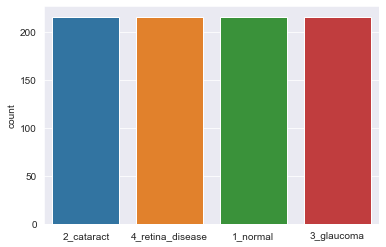

In [31]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Test Dataset.

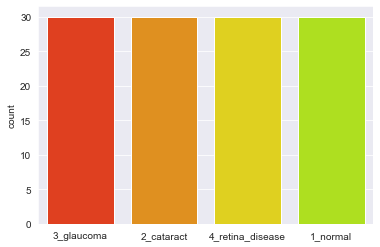

In [32]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l,palette='prism')

# Plot to Visualize the Number of Images in Each Label of Validation Dataset.

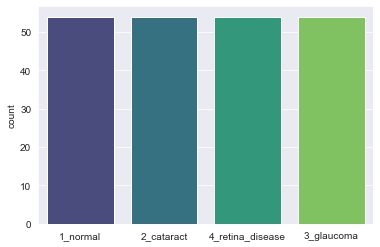

In [33]:
l = []
for i in validation:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l,palette='viridis')

# Training,Validation Accuracy and Loss Plot for 50 Epochs

In [34]:
def plot_print(i,j):
    epochs_range = range(50)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_acc[i:j], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[i:j], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_loss[i:j], label='Training Loss')
    plt.plot(epochs_range, val_loss[i:j], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

Plot for  1 cross validation accuracy and loss for Training and Validation phase


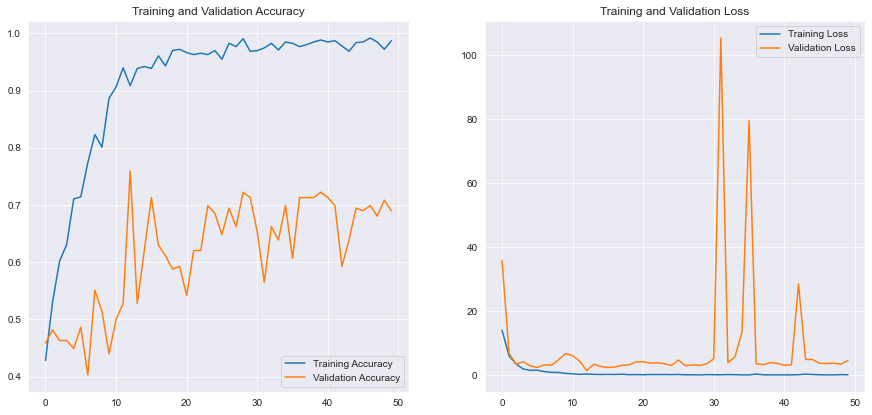

Plot for  2 cross validation accuracy and loss for Training and Validation phase


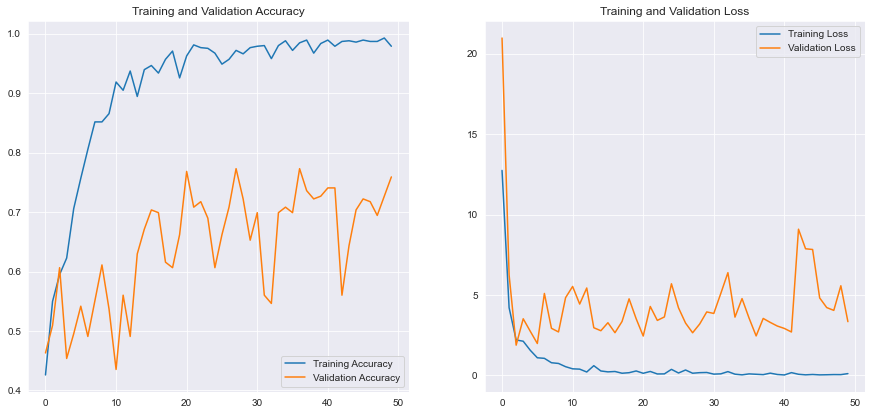

Plot for  3 cross validation accuracy and loss for Training and Validation phase


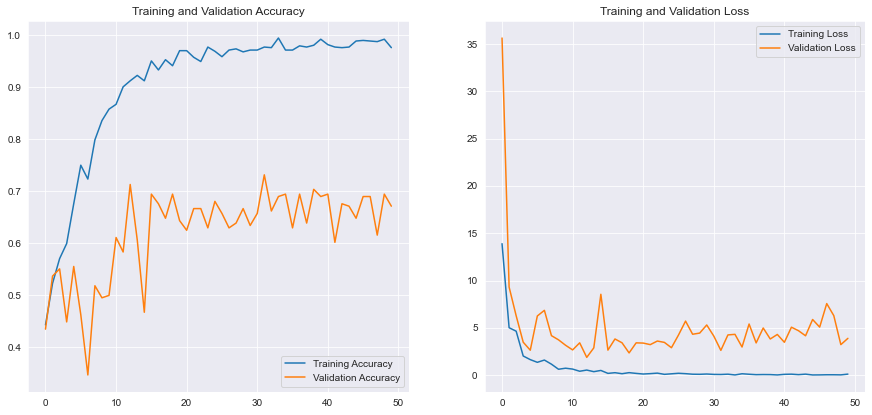

Plot for  4 cross validation accuracy and loss for Training and Validation phase


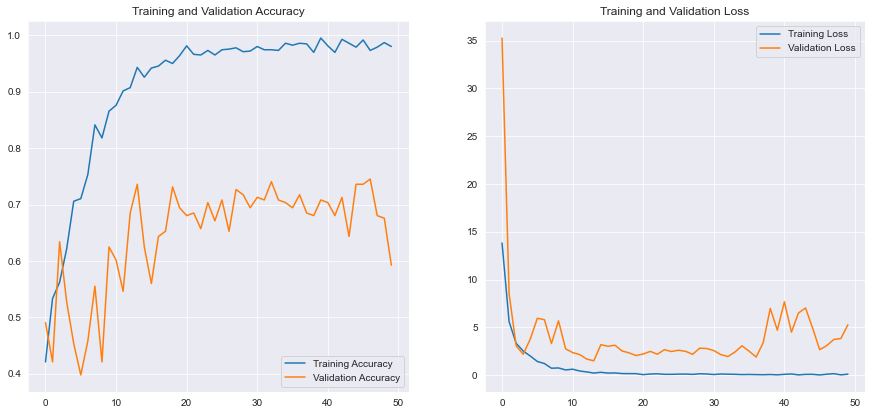

Plot for  5 cross validation accuracy and loss for Training and Validation phase


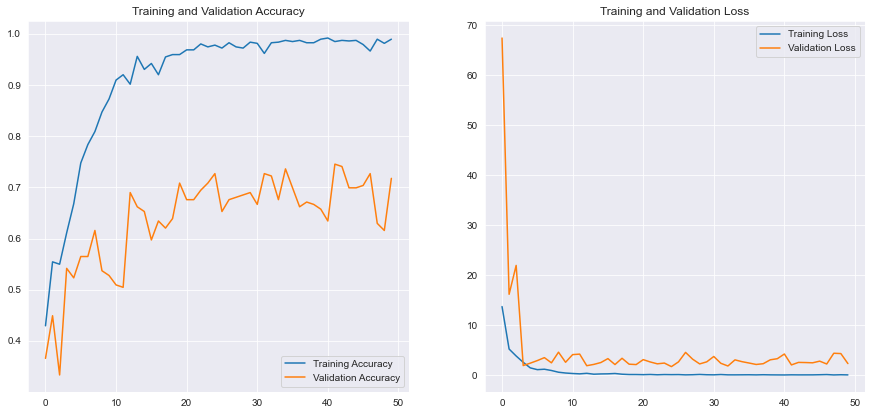

In [35]:
k=1
j=0
for i in range(0,250,50):
    j +=50
    print('Plot for ',k,'cross validation accuracy and loss for Training and Validation phase')
    k +=1
    plot_print(i,j)

# Visualizing Confusion Matrix for Each Fold

In [36]:
CM= np.array(CM)
CM.resize(5,4,4)

In [37]:
def confusionmatrix_vis(i):

        yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        plt.figure(figsize=(8, 8))
        hm =sns.heatmap(CM[i], annot=True,annot_kws={"size": 20}, cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

        hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

        plt.ylabel("Actual", fontsize = 18)
        plt.xlabel("Predicted",fontsize = 18)
      
        return plt.show()

Confusion Matrix for  1 Cross Validation Test phase


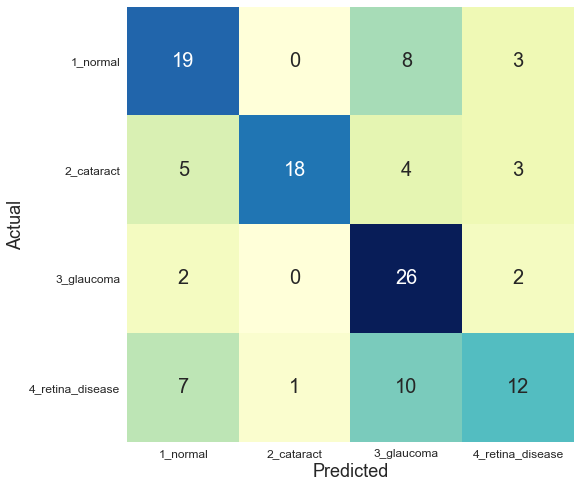

Confusion Matrix for  2 Cross Validation Test phase


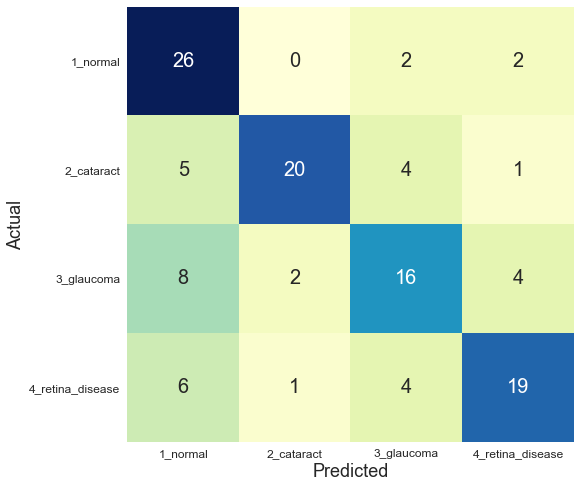

Confusion Matrix for  3 Cross Validation Test phase


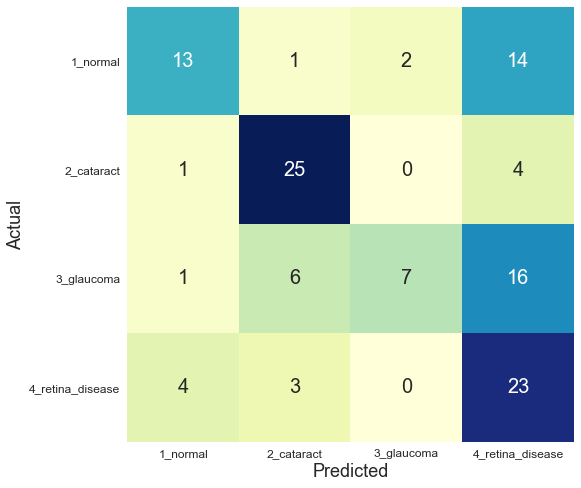

Confusion Matrix for  4 Cross Validation Test phase


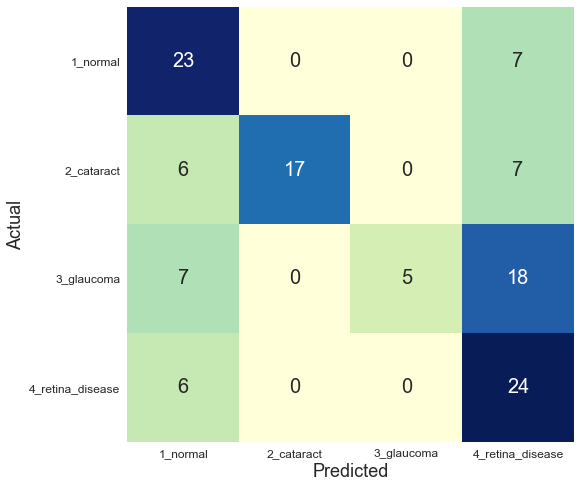

Confusion Matrix for  5 Cross Validation Test phase


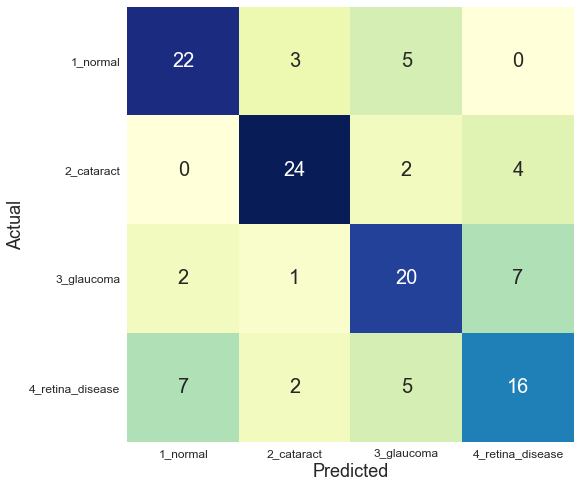

In [38]:
k=1
for i in range(5):    
    print('Confusion Matrix for ',k,'Cross Validation Test phase')
    k +=1
    confusionmatrix_vis(i)

# Visualizing Summarized Confusion Matrix of all 5 folds

In [39]:
CM_sum = CM[0]+CM[1]+CM[2]+CM[3]+CM[4]
CM_sum

array([[103,   4,  17,  26],
       [ 17, 104,  10,  19],
       [ 20,   9,  74,  47],
       [ 30,   7,  19,  94]], dtype=int64)

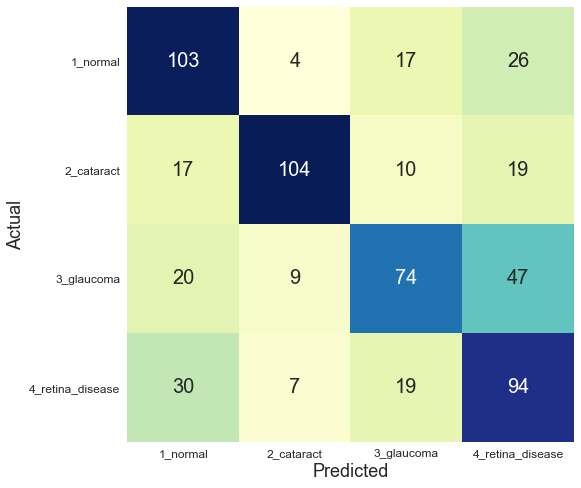

In [40]:
yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
plt.figure(figsize=(8, 8))
hm =sns.heatmap(CM_sum, annot=True,annot_kws={"size": 20},fmt='g', cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

plt.ylabel("Actual", fontsize = 18)
plt.xlabel("Predicted",fontsize = 18)
      
plt.show()

# Reconfirming the values of Accuracy,Sensitivity and Specificity

In [41]:
    sensitivity_1_normal = (CM_sum[0,0])/(CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (CM_sum[1,1])/(CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (CM_sum[2,2])/(CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (CM_sum[3,3])/(CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[1,0]+CM_sum[2,0]+CM_sum[3,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[0,1]+CM_sum[2,1]+CM_sum[3,1]+CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])/(CM_sum[0,2]+CM_sum[1,2]+CM_sum[3,2]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])/(CM_sum[0,3]+CM_sum[1,3]+CM_sum[2,3]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(CM_sum))
    test_accuracy=(CM_sum[0,0]+CM_sum[1,1]+CM_sum[2,2]+CM_sum[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)

Accuracy    :  0.625
Specificity :  0.8386044311512217
Sensitivity :  0.625


# Model Summary

In [42]:
model_build_compile(k)

model building and compiling for fold 7


In [43]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_824 (BatchN (None, 111, 111, 32) 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 111, 111, 32) 0           batch_normalization_824[0][0]    
____________________________________________________________________________________________

conv2d_990 (Conv2D)             (None, 5, 5, 256)    172032      activation_989[0][0]             
__________________________________________________________________________________________________
batch_normalization_999 (BatchN (None, 5, 5, 192)    576         conv2d_987[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1002 (Batch (None, 5, 5, 256)    768         conv2d_990[0][0]                 
__________________________________________________________________________________________________
activation_987 (Activation)     (None, 5, 5, 192)    0           batch_normalization_999[0][0]    
__________________________________________________________________________________________________
activation_990 (Activation)     (None, 5, 5, 256)    0           batch_normalization_1002[0][0]   
__________________________________________________________________________________________________
block8_4_m